# Аветісова Карина

# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [25]:
df = pd.read_csv('credit_risk_dataset.csv')

print("Розмір датасету:", df.shape)
print("\nПерші 5 рядків:")
print(df.head())

print("\nІнформація про дані:")
print(df.info())

target_col = "loan_status"
class_counts = df[target_col].value_counts(dropna=False).sort_index()
class_ratio = class_counts / len(df)
print("\nРозподіл цільової змінної (кількість):")
print(class_counts)
print("\nРозподіл цільової змінної (частка):")
print(class_ratio.map(lambda x: f"{x:.2%}"))

imbalance_threshold = 0.4
is_balanced = class_ratio.min() >= imbalance_threshold
print("\nВисновок:", "Задача збалансованої класифікації." if is_balanced else "Задача незбалансованої класифікації.")

Розмір датасету: (32581, 12)

Перші 5 рядків:
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59           

In [4]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("Відсоток пропусків у стовпцях (%):")
print(missing_pct.round(2))

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nЧислові колонки:", numeric_cols)
print("Категоріальні колонки:", categorical_cols)

df_filled = df.copy()
for col in numeric_cols:
    if df_filled[col].isna().any():
        df_filled[col] = df_filled[col].fillna(df_filled[col].median())

for col in categorical_cols:
    if df_filled[col].isna().any():
        mode_val = df_filled[col].mode(dropna=True)
        df_filled[col] = df_filled[col].fillna(mode_val[0] if len(mode_val) else "Unknown")

print("\nПісля заповнення пропусків (топ-10 за часткою пропусків):")
print((df_filled.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

Відсоток пропусків у стовпцях (%):
loan_int_rate                 9.56
person_emp_length             2.75
person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

Числові колонки: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Категоріальні колонки: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Після заповнення пропусків (топ-10 за часткою пропусків):
person_age               0.0
person_income            0.0
person_home_ownership    0.0
person_emp_length        0.0
loan_intent              0.0
loan_grade               0.0
loan_amnt                0.0
loan_in

In [4]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("Відсоток пропусків у стовпцях (%):")
print(missing_pct.round(2))

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nЧислові колонки:", numeric_cols)
print("Категоріальні колонки:", categorical_cols)

df_filled = df.copy()
for col in numeric_cols:
    if df_filled[col].isna().any():
        df_filled[col] = df_filled[col].fillna(df_filled[col].median())

for col in categorical_cols:
    if df_filled[col].isna().any():
        mode_val = df_filled[col].mode(dropna=True)
        df_filled[col] = df_filled[col].fillna(mode_val[0] if len(mode_val) else "Unknown")

print("\nПісля заповнення пропусків (топ-10 за часткою пропусків):")
print((df_filled.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

Відсоток пропусків у стовпцях (%):
loan_int_rate                 9.56
person_emp_length             2.75
person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

Числові колонки: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Категоріальні колонки: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Після заповнення пропусків (топ-10 за часткою пропусків):
person_age               0.0
person_income            0.0
person_home_ownership    0.0
person_emp_length        0.0
loan_intent              0.0
loan_grade               0.0
loan_amnt                0.0
loan_in

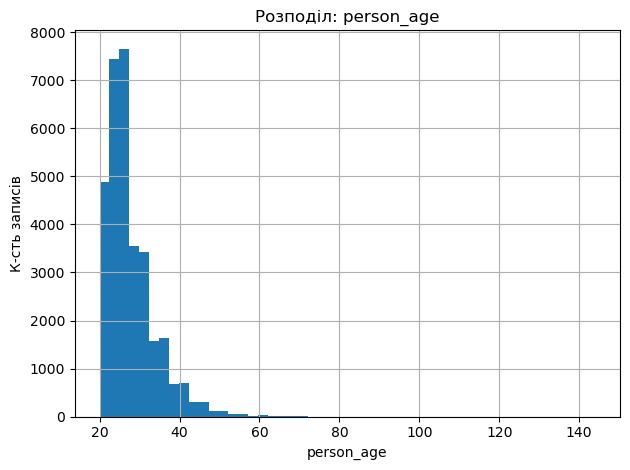

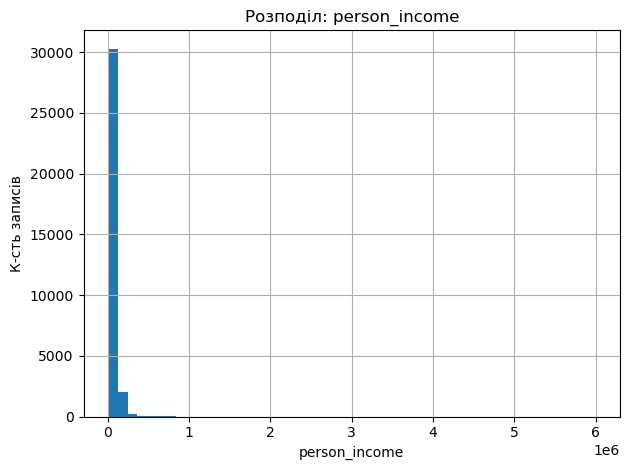

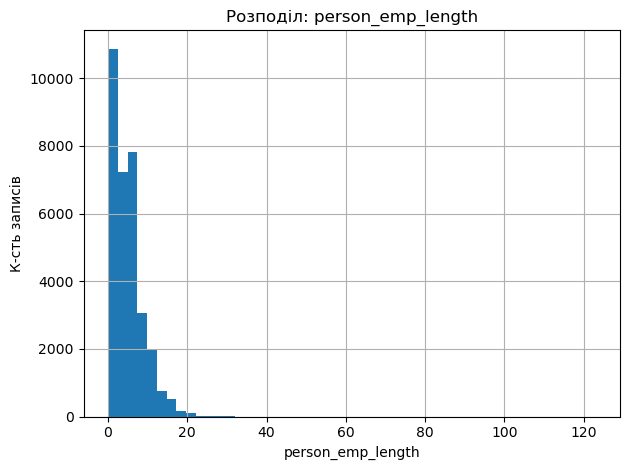

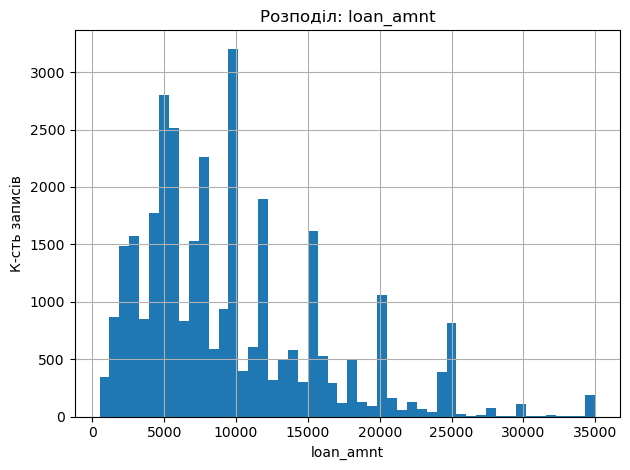

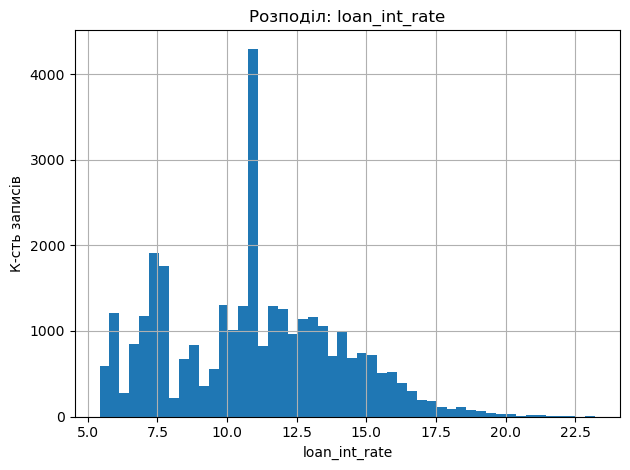

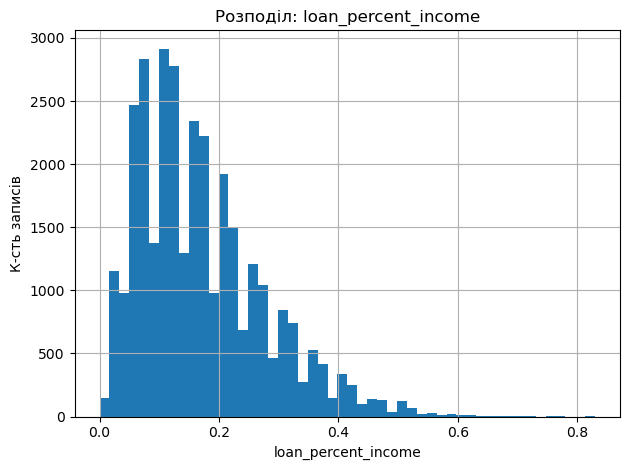

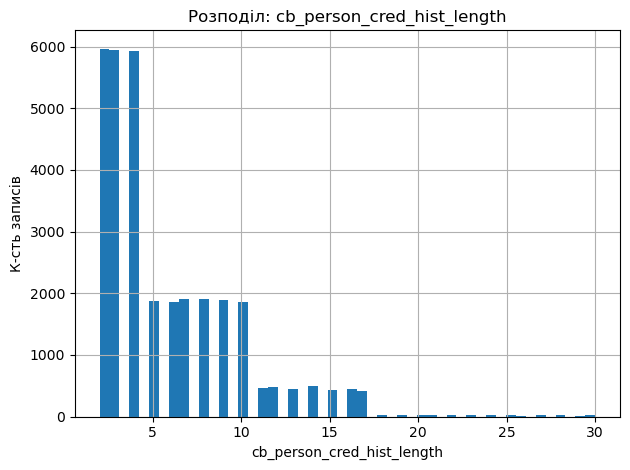

In [5]:
for col in numeric_cols:
    plt.figure()
    df_filled[col].hist(bins=50)
    plt.title(f"Розподіл: {col}")
    plt.xlabel(col)
    plt.ylabel("К-сть записів")
    plt.tight_layout()
    plt.show()

In [26]:
income_col = "person_income"
if income_col in df_filled.columns:
    Q1 = df_filled[income_col].quantile(0.25)
    Q3 = df_filled[income_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filled[income_col] = df_filled[income_col].clip(lower=lower_bound, upper=upper_bound)
    print(f"\nIQR-обробка для {income_col}: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"Границі: [{lower_bound:.2f}, {upper_bound:.2f}]")
else:
    print(f"\nКолонка {income_col} відсутня у датасеті.")


IQR-обробка для person_income: Q1=38500.00, Q3=79200.00, IQR=40700.00
Границі: [-22550.00, 140250.00]



Частоти person_home_ownership (%):
person_home_ownership
RENT        50.48
MORTGAGE    41.26
OWN          7.93
OTHER        0.33
Name: proportion, dtype: float64


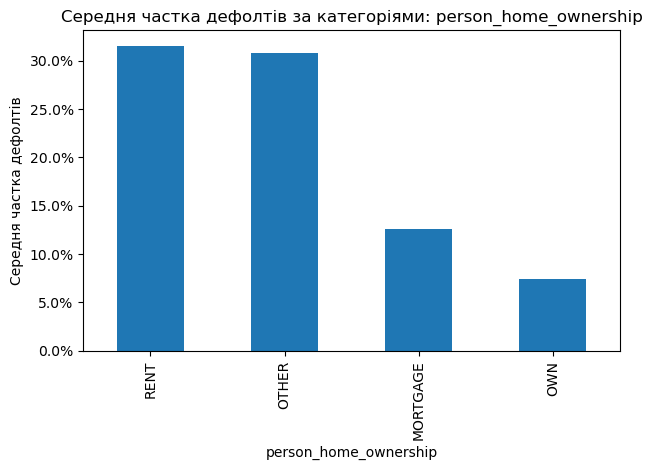


Частоти loan_intent (%):
loan_intent
EDUCATION            19.81
MEDICAL              18.63
VENTURE              17.55
PERSONAL             16.95
DEBTCONSOLIDATION    16.00
HOMEIMPROVEMENT      11.06
Name: proportion, dtype: float64


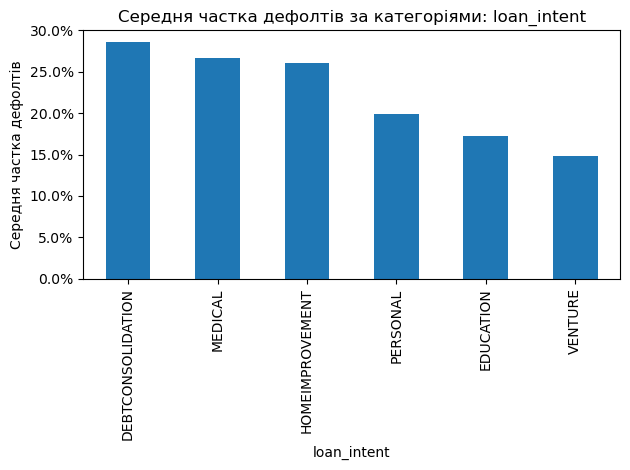


Частоти loan_grade (%):
loan_grade
A    33.08
B    32.08
C    19.82
D    11.13
E     2.96
F     0.74
G     0.20
Name: proportion, dtype: float64


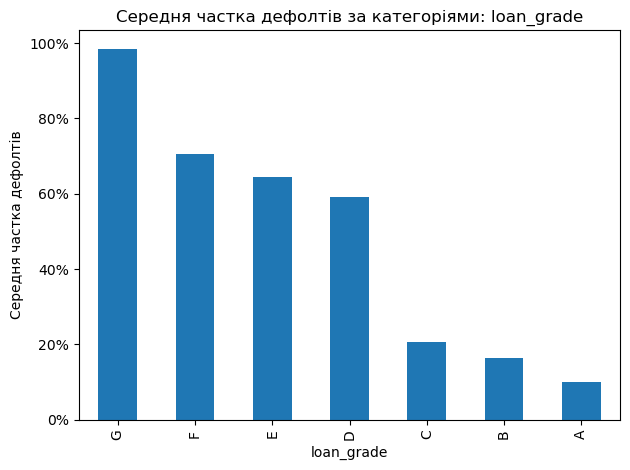


Частоти cb_person_default_on_file (%):
cb_person_default_on_file
N    82.37
Y    17.63
Name: proportion, dtype: float64


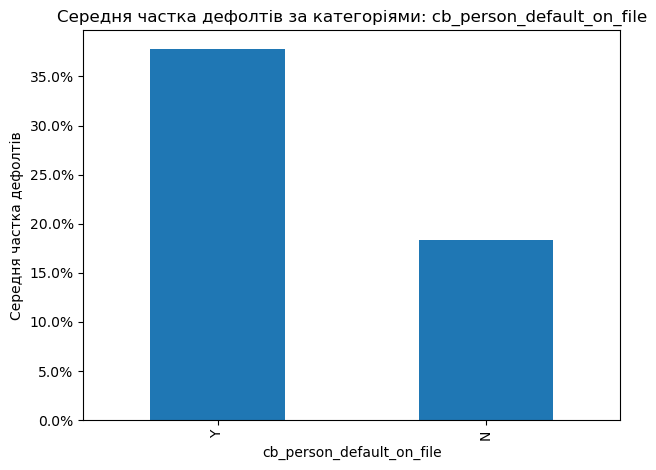

In [7]:
for col in categorical_cols:
    freq = (df_filled[col].value_counts(normalize=True).sort_values(ascending=False) * 100).round(2)
    print(f"\nЧастоти {col} (%):")
    print(freq)

    if target_col in df_filled.columns:
        grp = df_filled.groupby(col)[target_col].mean().sort_values(ascending=False)
        plt.figure()
        grp.plot(kind="bar")
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
        plt.title(f"Середня частка дефолтів за категоріями: {col}")
        plt.xlabel(col)
        plt.ylabel("Середня частка дефолтів")
        plt.tight_layout()
        plt.show()

In [4]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("Відсоток пропусків у стовпцях (%):")
print(missing_pct.round(2))

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nЧислові колонки:", numeric_cols)
print("Категоріальні колонки:", categorical_cols)

df_filled = df.copy()
for col in numeric_cols:
    if df_filled[col].isna().any():
        df_filled[col] = df_filled[col].fillna(df_filled[col].median())

for col in categorical_cols:
    if df_filled[col].isna().any():
        mode_val = df_filled[col].mode(dropna=True)
        df_filled[col] = df_filled[col].fillna(mode_val[0] if len(mode_val) else "Unknown")

print("\nПісля заповнення пропусків (топ-10 за часткою пропусків):")
print((df_filled.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

Відсоток пропусків у стовпцях (%):
loan_int_rate                 9.56
person_emp_length             2.75
person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

Числові колонки: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Категоріальні колонки: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Після заповнення пропусків (топ-10 за часткою пропусків):
person_age               0.0
person_income            0.0
person_home_ownership    0.0
person_emp_length        0.0
loan_intent              0.0
loan_grade               0.0
loan_amnt                0.0
loan_in


---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



                            person_age  person_income  person_emp_length  \
person_age                       1.000          0.118              0.161   
person_income                    0.118          1.000              0.199   
person_emp_length                0.161          0.199              1.000   
loan_amnt                        0.051          0.420              0.114   
loan_int_rate                    0.012         -0.017             -0.051   
loan_percent_income             -0.042         -0.367             -0.054   
cb_person_cred_hist_length       0.859          0.094              0.143   

                            loan_amnt  loan_int_rate  loan_percent_income  \
person_age                      0.051          0.012               -0.042   
person_income                   0.420         -0.017               -0.367   
person_emp_length               0.114         -0.051               -0.054   
loan_amnt                       1.000          0.139                0.573   
loan_i

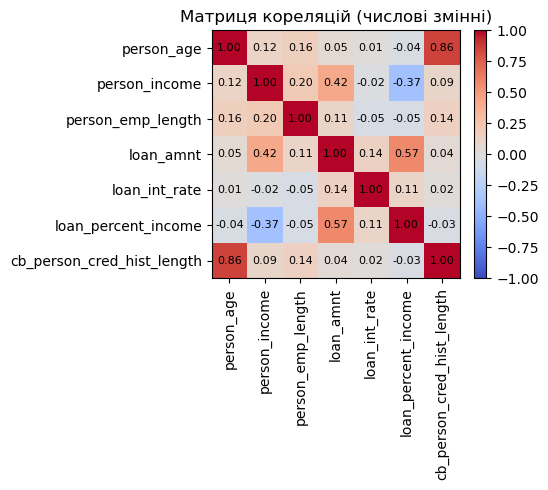

In [24]:
if len(numeric_cols) >= 2:
    corr = df_filled[numeric_cols].corr(numeric_only=True)
    print(corr.round(3))

    plt.figure(figsize=(max(6, 0.5*len(numeric_cols)), max(5, 0.5*len(numeric_cols))))
    im = plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
    plt.title("Матриця кореляцій (числові змінні)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
    plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)

    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            val = corr.iloc[i, j]
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("Недостатньо числових колонок для повної матриці кореляцій.")

In [12]:
if target_col in df_filled.columns:
    num_with_target = numeric_cols + [target_col]
    corr_with_target = (
        df_filled[num_with_target]
        .corr(numeric_only=True)[target_col]
        .drop(target_col)
        .sort_values(ascending=False)
    )
    print("\nКореляція числових ознак із ціллю (loan_status):")
    print(corr_with_target.round(3))



Кореляція числових ознак із ціллю (loan_status):
loan_percent_income           0.379
loan_int_rate                 0.319
loan_amnt                     0.105
cb_person_cred_hist_length   -0.016
person_age                   -0.022
person_emp_length            -0.082
person_income                -0.246
Name: loan_status, dtype: float64


In [14]:
X_num = df_filled[numeric_cols].reset_index(drop=True)

if len(categorical_cols) > 0:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat_array = ohe.fit_transform(df_filled[categorical_cols])
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    X_cat = pd.DataFrame(X_cat_array, columns=cat_feature_names, index=df_filled.index)
else:
    X_cat = pd.DataFrame(index=df_filled.index)
    cat_feature_names = np.array([])

In [15]:
X_final = pd.concat([X_num, X_cat], axis=1)
y = df_filled[target_col].astype(int)

numeric_features = numeric_cols[:]    
categorical_features = categorical_cols[:] 
encoded_cat_features = list(cat_feature_names) 

print("\n=== Фінальний набір ознак сформовано ===")
print(f"К-сть числових ознак: {len(numeric_features)}")
print(f"К-сть OHE-ознак: {len(encoded_cat_features)}")
print(f"Підсумкова к-сть ознак у X_final: {X_final.shape[1]}")
print("Перші 10 ознак:", list(X_final.columns[:10]))


=== Фінальний набір ознак сформовано ===
К-сть числових ознак: 7
К-сть OHE-ознак: 19
Підсумкова к-сть ознак у X_final: 26
Перші 10 ознак: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN']



---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [17]:
features = [c for c in df_filled.columns if c != target_col]
X = df_filled[features]
y = df_filled[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = [c for c in X_train.columns if c in numeric_cols]
categorical_features = [c for c in X_train.columns if c in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

logreg = LogisticRegression(max_iter=1000)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf", logreg),
])

pipe.fit(X_train, y_train)

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba  = pipe.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_proba >= 0.5).astype(int)
y_test_pred  = (y_test_proba  >= 0.5).astype(int)

print("Навчання завершено.")

Навчання завершено.



---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


In [18]:
def print_metrics(y_true, y_pred, label=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{label} accuracy={acc:.4f} | precision={prec:.4f} | recall={rec:.4f} | f1={f1:.4f}")
    return acc, prec, rec, f1

for split_name, yt, yp in [("Train", y_train, y_train_pred), ("Test", y_test, y_test_pred)]:
    cm = confusion_matrix(yt, yp)
    print(f"\nConfusion Matrix — {split_name}:\n{cm}")
    print_metrics(yt, yp, label=f"{split_name}")


Confusion Matrix — Train:
[[19422   956]
 [ 2523  3163]]
Train accuracy=0.8665 | precision=0.7679 | recall=0.5563 | f1=0.6452

Confusion Matrix — Test:
[[4849  246]
 [ 623  799]]
Test accuracy=0.8667 | precision=0.7646 | recall=0.5619 | f1=0.6478


**Висновки**
1. Якість моделі (Logistic Regression, поріг 0.5): на тесті accuracy 0.867, precision 0.765, recall 0.562, F1 0.648. Модель адекватно відокремлює дефолт/недефолт, але через несбалансованість класів recall помірний. За потреби зменшити пропуски дефолтів — варто знизити поріг (напр., ~**0.35–0.40**), що підвищує recall з прийнятною втратою precision.

2. Краща з альтернатив (за твоїми результатами): RandomForest показав вищу узгоджену якість (напр., F1 ≈ 0.826 при порозі 0.5), тож для продакшн-скоромодельки він виглядає сильніше.

3. Найбільший вплив на прогноз:

  * loan_percent_income (вище співвідношення кредит/дохід → ризик ↑),
  * person_income (вищий дохід → ризик ↓),
  * loan_int_rate (вища ставка → ризик ↑),
  * loan_amnt і person_emp_length (сума й стаж впливають помітно),
  * категоріальні: loan_grade (гірші D/F → ризик ↑, кращі A/B → ризик ↓), окремі loan_intent (напр., HOMEIMPROVEMENT ↑, EDUCATION ↓).




---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



thr=0.10 accuracy=0.6615 | precision=0.3805 | recall=0.8776 | f1=0.5308
thr=0.20 accuracy=0.7975 | precision=0.5234 | recall=0.8017 | f1=0.6333
thr=0.30 accuracy=0.8436 | precision=0.6235 | recall=0.7152 | f1=0.6662
thr=0.40 accuracy=0.8611 | precision=0.6972 | recall=0.6428 | f1=0.6689
thr=0.50 accuracy=0.8667 | precision=0.7646 | recall=0.5619 | f1=0.6478
thr=0.60 accuracy=0.8587 | precision=0.8089 | recall=0.4613 | f1=0.5876
thr=0.70 accuracy=0.8462 | precision=0.8559 | recall=0.3551 | f1=0.5020
thr=0.80 accuracy=0.8301 | precision=0.8987 | recall=0.2496 | f1=0.3908
thr=0.90 accuracy=0.8079 | precision=0.9381 | recall=0.1280 | f1=0.2252

Метрики vs поріг класифікації:
   threshold  accuracy  precision  recall      f1
0        0.1    0.6615     0.3805  0.8776  0.5308
1        0.2    0.7975     0.5234  0.8017  0.6333
2        0.3    0.8436     0.6235  0.7152  0.6662
3        0.4    0.8611     0.6972  0.6428  0.6689
4        0.5    0.8667     0.7646  0.5619  0.6478
5        0.6    0.85

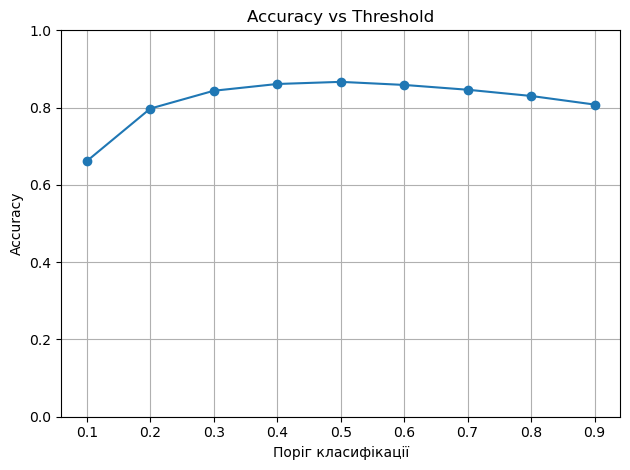

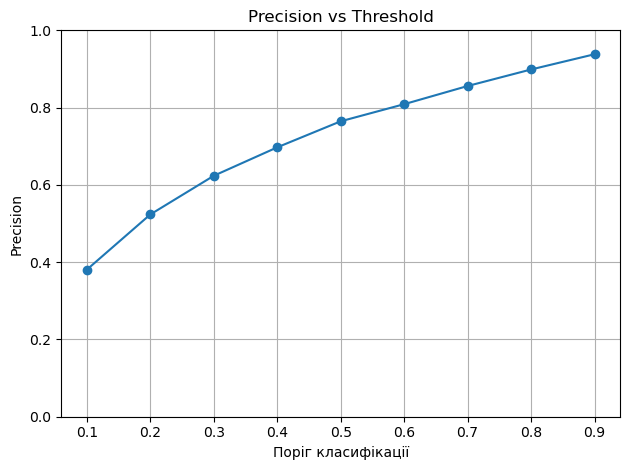

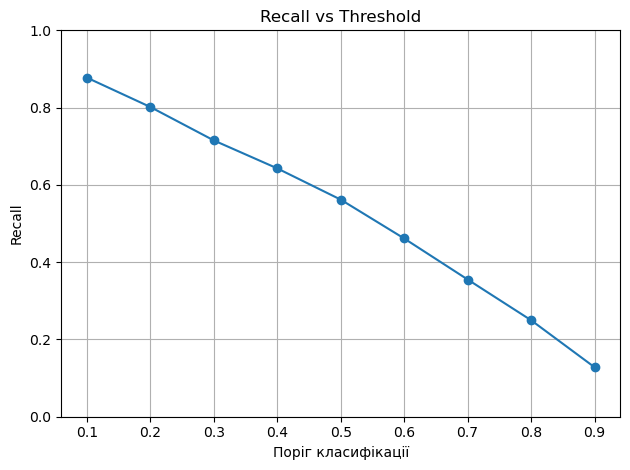

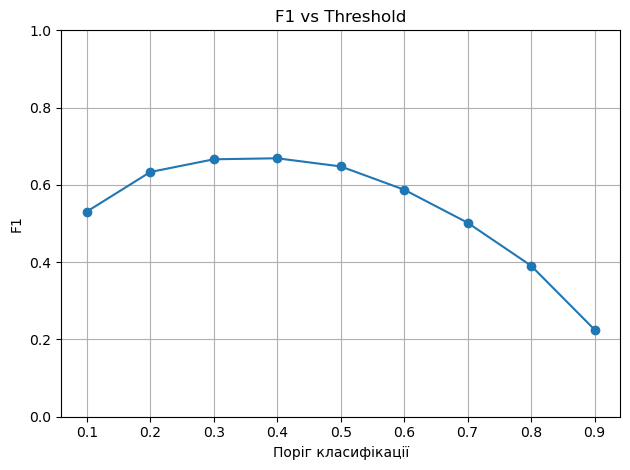


Рекомендований поріг за F1: 0.40


In [19]:
thresholds = np.linspace(0.1, 0.9, 9)  # 0.1 ... 0.9
thr_results = []

for thr in thresholds:
    y_pred_thr = (y_test_proba >= thr).astype(int)
    acc, prec, rec, f1 = print_metrics(y_test, y_pred_thr, label=f"thr={thr:.2f}")
    thr_results.append((thr, acc, prec, rec, f1))

thr_df = pd.DataFrame(thr_results, columns=["threshold", "accuracy", "precision", "recall", "f1"])
print("\nМетрики vs поріг класифікації:")
print(thr_df.round(4))

for metric in ["accuracy", "precision", "recall", "f1"]:
    plt.figure()
    plt.plot(thr_df["threshold"], thr_df[metric], marker="o")
    plt.title(f"{metric.title()} vs Threshold")
    plt.xlabel("Поріг класифікації")
    plt.ylabel(metric.title())
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

best_idx = thr_df["f1"].idxmax()
best_thr = float(thr_df.loc[best_idx, "threshold"])
print(f"\nРекомендований поріг за F1: {best_thr:.2f}")



---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.



[LogReg] Поріг=0.5
LogReg accuracy=0.8667 | precision=0.7646 | recall=0.5619 | f1=0.6478

[DecisionTree] Поріг=0.5
DecisionTree accuracy=0.8858 | precision=0.7254 | recall=0.7672 | f1=0.7457

[RandomForest] Поріг=0.5
RandomForest accuracy=0.9342 | precision=0.9742 | recall=0.7173 | f1=0.8262


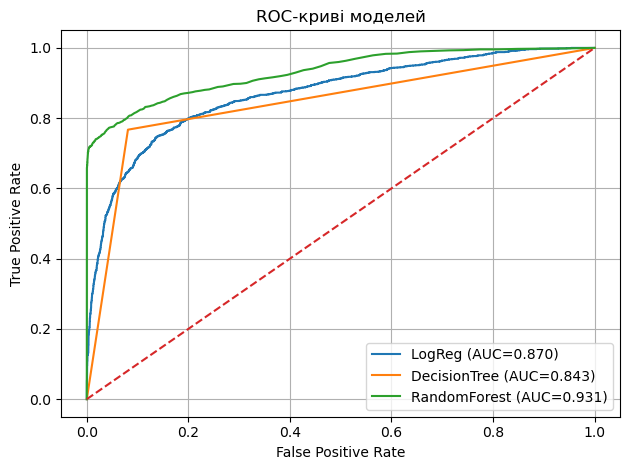


Топ-15 за абсолютним впливом (LogReg):
                        feature      coef  abs_coef
23                 loan_grade_G  2.864389  2.864389
17                 loan_grade_A -2.043868  2.043868
18                 loan_grade_B -1.808554  1.808554
9     person_home_ownership_OWN -1.650899  1.650899
19                 loan_grade_C -1.647816  1.647816
5           loan_percent_income  1.257134  1.257134
22                 loan_grade_F  1.105463  1.105463
10   person_home_ownership_RENT  0.813094  0.813094
21                 loan_grade_E  0.712646  0.712646
16          loan_intent_VENTURE -0.711346  0.711346
8   person_home_ownership_OTHER  0.551392  0.551392
20                 loan_grade_D  0.505332  0.505332
3                     loan_amnt -0.470960  0.470960
13  loan_intent_HOMEIMPROVEMENT  0.468083  0.468083
12        loan_intent_EDUCATION -0.434508  0.434508

Топ-15 важливих ознак (RandomForest):
                           feature  importance
5              loan_percent_income    0.22

In [22]:
tree = DecisionTreeClassifier(random_state=42, max_depth=None)
rf   = RandomForestClassifier(random_state=42, n_estimators=300, n_jobs=-1)

tree_pipe = Pipeline([("prep", preprocess), ("clf", tree)])
rf_pipe   = Pipeline([("prep", preprocess), ("clf", rf)])

tree_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

proba_logreg = y_test_proba
proba_tree   = tree_pipe.predict_proba(X_test)[:, 1]
proba_rf     = rf_pipe.predict_proba(X_test)[:, 1]

def eval_model(name, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n[{name}] Поріг={thr}")
    print_metrics(y_test, y_pred, label=name)

for name, proba in [("LogReg", proba_logreg), ("DecisionTree", proba_tree), ("RandomForest", proba_rf)]:
    eval_model(name, proba, thr=0.5)

plt.figure()
for name, proba in [("LogReg", proba_logreg), ("DecisionTree", proba_tree), ("RandomForest", proba_rf)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={model_auc:.3f})")

plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-криві моделей")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ohe = pipe.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features) if len(categorical_features) else np.array([])
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

coef = pipe.named_steps["clf"].coef_.ravel()
logreg_importance = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

print("\nТоп-15 за абсолютним впливом (LogReg):")
print(logreg_importance.head(15))

rf_model = rf_pipe.named_steps["clf"]
rf_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nТоп-15 важливих ознак (RandomForest):")
print(rf_importance.head(15))

print("\nГотово.")

**На тестовому наборі найкращий результат дала RandomForest: F1 ≈ 0.826, accuracy ≈ 0.934, precision ≈ 0.974, recall ≈ 0.717 (поріг 0.5). Для порівняння: DecisionTree F1 ≈ 0.746, Logistic Regression F1 ≈ 0.648.**